# Acoustic Data Feature Extraction Notebook - Word Modeling

## Import Packages

In [1]:
# Audio processing
import librosa
import librosa.display as ld
import IPython.display as ipd
# Data cleaning
import os
import pandas as pd
import numpy as np
from numpy import mean, var
# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# Statistics
from sklearn.decomposition import PCA
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split
# Advanced options
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")

-----

-----

## Define Constants

In [2]:
FRAMESIZE = 1024
HOPLENGTH = 512
# 13 mels for fingerprint and more than 20 mels for word detection
MELS = 20 
SPLITFREQ = 2000
PCA_N = 2

-----

-----

## Read Data

In [3]:
# Cluster data for future work
opd_data = []
others_data = []
directory= "A:\Professional\Engineering CU\DSP_Data_New"
for dir in os.listdir(directory):
    if dir == "open the door":
        for filename in os.listdir(os.path.join(directory, dir)):
            path_opd = os.path.join(directory, dir, filename)
            opd_data.append(path_opd)
    else:
        for filename in os.listdir(os.path.join(directory, dir)):
            path_others = os.path.join(directory, dir, filename)
            others_data.append(path_others)

In [4]:
# Group all the data
data = []
data.extend(opd_data)
data.extend(others_data)

-----

-----

## Extract Features

In [5]:
# Functions we will use
def transform_audio(audio, FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ):
    
    audio_array, sr = librosa.load(audio)
    ae_audio = fancy_amplitude_envelope(audio_array, FRAMESIZE, HOPLENGTH)
    rms_audio = librosa.feature.rms(audio_array, frame_length=FRAMESIZE, hop_length=HOPLENGTH)[0]
    mel_audio = librosa.feature.melspectrogram(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH, n_mels=MELS)
    log_mel_audio = librosa.power_to_db(mel_audio)[0]
    mfccs_audio = librosa.feature.mfcc(y=audio_array, n_mfcc=MELS, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    sc_audio = librosa.feature.spectral_centroid(y=audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    chromagram_audio = librosa.feature.chroma_stft(audio_array, sr=sr, n_fft=FRAMESIZE, hop_length=HOPLENGTH)[0]
    tone_audio = librosa.feature.tonnetz(y=audio_array, sr=sr)[0]
    
#     return np.hstack((log_mel_audio, mfccs_audio, sc_audio, rms_audio, ae_audio, chromagram_audio, tone_audio))
    return np.hstack((mean(log_mel_audio), var(log_mel_audio), mean(mfccs_audio), var(mfccs_audio), mean(sc_audio), var(sc_audio), mean(ae_audio), var(ae_audio), mean(chromagram_audio), var(chromagram_audio), mean(tone_audio), var(tone_audio)))


def fancy_amplitude_envelope(signal, framesize, hoplength):
    return np.array([max(signal[i:i+framesize]) for i in range(0, len(signal), hoplength)])

In [6]:
def get_data_features(data, big_chunk='no'):
    z = len(data)
    if big_chunk == 'yes':
        features_length = len(transform_audio(data[0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ))
    else:
        features_length = len(transform_audio(data[0], FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ))
        
    # Data Features
    df = pd.DataFrame()
    df['data'] = data

    for i in tqdm(range(features_length)):
        df[f'feature {i}'] = np.zeros(z)

    temp_array = []
    for index, row in tqdm(df.iloc[:].iterrows()):
        if index < len(df)-1:
            if big_chunk == 'yes':
                array_1 = transform_audio(df.loc[index, ['data']][0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ)
                array_2 = transform_audio(df.loc[index+1, ['data']][0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ)
            else:
                array_1 = transform_audio(df.loc[index, ['data']][0], FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ)
                array_2 = transform_audio(df.loc[index+1, ['data']][0], FRAMESIZE, HOPLENGTH, MELS, SPLITFREQ)
            combined_array = np.vstack((array_1, array_2))[0]
            temp_array.append(list(combined_array))

    last_element = transform_audio(df.loc[len(df)-1, ['data']][0], FRAMESIZE*4, HOPLENGTH*4, MELS, SPLITFREQ)
    temp_array.append(list(last_element))
    df.iloc[:,1:] = pd.DataFrame(temp_array).copy()
    df.fillna(0, inplace=True)
    
    return df

In [7]:
# Big chunk
df_big_otd = get_data_features(opd_data, big_chunk='yes')
df_big_others = get_data_features(others_data, big_chunk='yes')

df_big_otd['password'] = 1
df_big_others['password'] = 0

# Make whole data dataframe for selecting best features
df_big_data = df_big_otd.append(df_big_others, ignore_index = True)

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 702.85it/s]
42it [00:13,  3.00it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<?, ?it/s]
54it [00:18,  2.99it/s]


In [8]:
# Small chunk
df_small_otd = get_data_features(opd_data)
df_small_others = get_data_features(others_data)

df_small_otd['password'] = 1
df_small_others['password'] = 0

# Make whole data dataframe for selecting best features
df_small_data = df_small_otd.append(df_small_others, ignore_index = True)

100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 635.75it/s]
42it [00:13,  3.11it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 905.90it/s]
54it [00:17,  3.08it/s]


-----

-----

## Feature Engineering

- Now we will do some feature engineering to improve our features
    - We will depend upon Mutual information classification
    - After many trials we found that depeding `only` on correlation is useless

In [9]:
df_small_data.iloc[:,1:13]

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11
0,-27.176701,247.355957,-591.251709,12277.317383,1886.831218,812302.325372,0.027843,0.002087,0.637220,0.090833,-0.014063,0.001900
1,-31.745686,333.813995,-596.309570,13379.764648,1956.928862,638793.280123,0.033648,0.004332,0.475199,0.105591,0.004940,0.001837
2,-27.673738,279.615875,-595.602173,11657.736328,1822.757696,569811.932642,0.023385,0.001250,0.515015,0.096196,0.003447,0.003507
3,-27.113342,337.045288,-546.374390,9220.183594,1813.157956,754177.385738,0.051932,0.020891,0.452060,0.094325,0.002377,0.002053
4,-27.328915,296.400452,-586.068176,11761.992188,1940.781830,782546.842008,0.023735,0.001037,0.541509,0.086454,0.021529,0.004497
...,...,...,...,...,...,...,...,...,...,...,...,...
91,-28.039810,190.256241,-581.987122,10092.810547,1837.557431,526651.443523,0.032975,0.002687,0.389244,0.105017,0.003723,0.014739
92,-26.050203,174.556595,-580.651855,7988.495605,1674.314646,545260.877902,0.033168,0.002236,0.503347,0.143094,0.041774,0.008323
93,-27.849642,169.827972,-600.609863,7069.024902,1681.867204,496338.505689,0.024073,0.001499,0.321773,0.082482,0.084603,0.008024
94,-27.739689,331.523285,-568.336792,13784.242188,1829.838783,783304.313890,0.047651,0.005682,0.534416,0.114092,-0.015299,0.004378


In [10]:
df_big_data.iloc[:,1:13]

,feature 0,feature 1,feature 2,feature 3,feature 4,feature 5,feature 6,feature 7,feature 8,feature 9,feature 10,feature 11
0,-13.535290,223.624451,-441.285034,14687.514648,2022.772114,1.146488e+06,0.043756,0.003342,0.524418,0.084185,-0.014063,0.001900
1,-18.575626,340.839630,-447.589722,16826.134766,1993.755346,5.818932e+05,0.065452,0.010407,0.346460,0.051185,0.004940,0.001837
2,-14.357706,254.109467,-443.781036,13295.675781,1841.433549,4.840813e+05,0.036475,0.002278,0.421904,0.087743,0.003447,0.003507
3,-13.499399,346.688873,-434.511139,17937.117188,1802.323680,6.514805e+05,0.110395,0.061947,0.356140,0.058979,0.002377,0.002053
4,-14.551062,280.300262,-431.716034,14096.180664,2029.046813,6.972431e+05,0.036283,0.001656,0.545310,0.116371,0.021529,0.004497
...,...,...,...,...,...,...,...,...,...,...,...,...
91,-14.832839,157.933701,-432.491394,11932.806641,1886.573039,4.437952e+05,0.050703,0.004767,0.302877,0.091452,0.003723,0.014739
92,-13.022161,139.227219,-429.789917,9169.819336,1737.158088,4.664310e+05,0.049374,0.003613,0.431031,0.118920,0.041774,0.008323
93,-14.729757,141.964951,-453.278992,8710.605469,1741.683350,4.321974e+05,0.034607,0.002422,0.269358,0.051202,0.084603,0.008024
94,-14.968060,322.623627,-422.177704,18029.625000,1908.727778,5.711068e+05,0.077326,0.010786,0.473564,0.098640,-0.015299,0.004378


In [11]:
# Select best 20 features
X_train_feat_s, _, y_train_feat_s ,_ = train_test_split(df_small_data.drop(labels=['data', 'password'], axis=1),
    df_small_data.iloc[:,13],
    test_size=0.3,
    random_state=0)

mutual_info_classif(X_train_feat_s, y_train_feat_s)

sel_cols_s = SelectKBest(mutual_info_classif, k=5)
sel_cols_s.fit(X_train_feat_s, y_train_feat_s)
best_features_small = list(X_train_feat_s.columns[sel_cols_s.get_support()])
best_features_small

['feature 0', 'feature 2', 'feature 6', 'feature 7', 'feature 9']

In [12]:
# Select best 20 features
X_train_feat_b, _, y_train_feat_b ,_ = train_test_split(df_big_data.drop(labels=['data', 'password'], axis=1),
    df_big_data.iloc[:,13],
    test_size=0.3,
    random_state=0)

mutual_info_classif(X_train_feat_b, y_train_feat_b)

sel_cols_b = SelectKBest(mutual_info_classif, k=5)
sel_cols_b.fit(X_train_feat_b, y_train_feat_b)
best_features_big = list(X_train_feat_b.columns[sel_cols_b.get_support()])
best_features_big

['feature 0', 'feature 2', 'feature 7', 'feature 8', 'feature 9']

In [13]:
def stat_analysis(df, n):
    #-----------------------------------------------------------------------------------------
    # Check correlation
    corr = df.corr()

    # Set up the matplotlib plot configuration
    plt.figure(figsize=(35,10))

    plt.subplot(1,2,1)

    # Generate a mask for upper traingle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Configure a custom diverging colormap
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    # Draw the heatmap
    plt.title('Correlation')
    sns.heatmap(corr, annot=True, mask = mask, cmap=cmap)


    #-----------------------------------------------------------------------------------------
    # Perform PCA to make dimensionality reduction 
    pca = PCA()

    # Fit the standardized data to the pca
    pca=pca.fit(df)

    # Plot the proportion of variance explained on the y-axis of the bar plot
    # Set up the matplotlib plot configuration    
    plt.subplot(1,2,2)
    plt.title('PCA')    
    plt.bar(range(1, pca.n_components_ + 1),  pca.explained_variance_ratio_)
    plt.xlabel('Principal component #')
    plt.ylabel('Proportion of variance explained')
    plt.xticks(range(df.shape[1]))

    two_first_comp_var_exp = pca.explained_variance_ratio_.cumsum()[n]
    print("The cumulative variance of the first 2 principal components is {}".format(
    round(two_first_comp_var_exp, 5)))

The cumulative variance of the first 2 principal components is 1.0


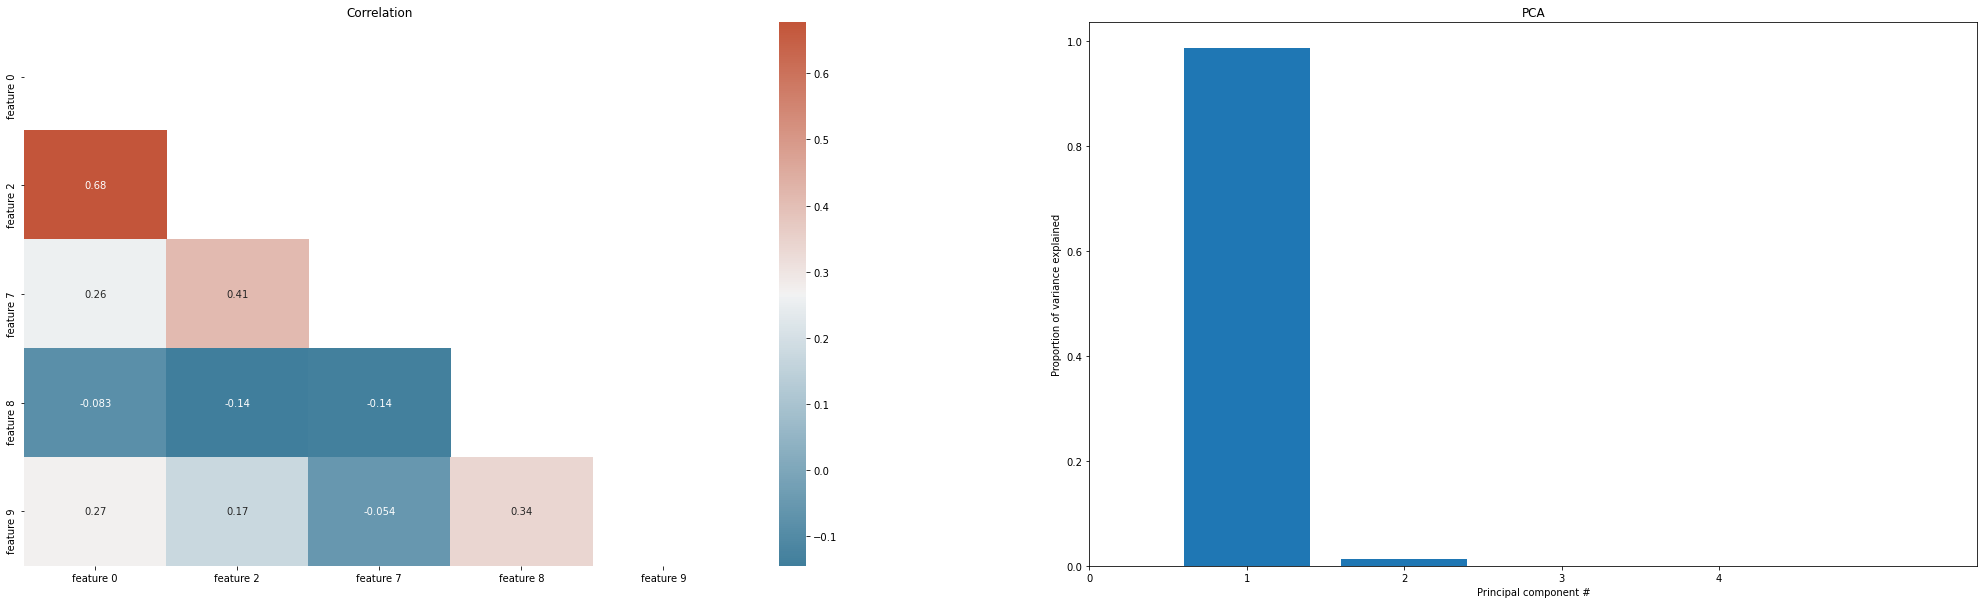

In [14]:
stat_analysis(df_big_data[best_features_big].iloc[:,:], 2)

The cumulative variance of the first 2 principal components is 1.0


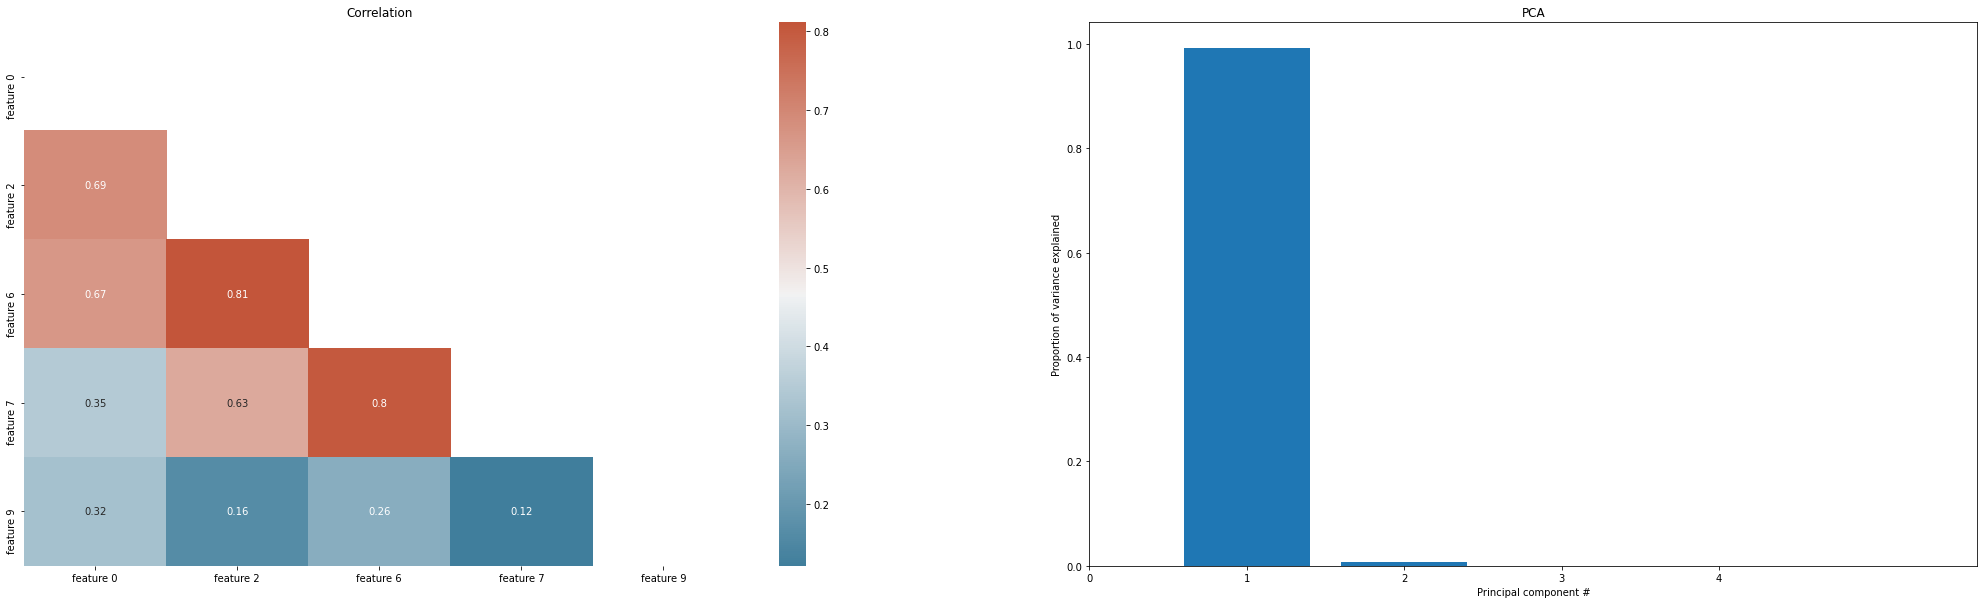

In [15]:
stat_analysis(df_small_data[best_features_small].iloc[:,:], 2)

- We notice that we can retrieve most of our data's information at 2 pca components

-----

-----

## Save Data

In [16]:
depended_features_small = np.savetxt("A:\OpenSesame\data\\word_features_small.csv", best_features_small, delimiter =", ", fmt ='% s')
depended_features_big = np.savetxt("A:\OpenSesame\\data\\word_features_big.csv", best_features_big, delimiter =", ", fmt ='% s')

In [17]:
df_big_data[best_features_big].to_csv('A:\OpenSesame\data\\big_chunk_word.csv', index=False)
df_small_data[best_features_small].to_csv('A:\OpenSesame\data\\small_chunk_word.csv', index=False)
df_big_data['password'].to_csv('A:\OpenSesame\data\\target_data_word.csv', index=False)

After exporting our data lets go for our model building notebook.